In [124]:
#Spark installation if needed
!pip install pyspark
!pip install findspark

In [125]:
#Check for spark session
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("DataTransformation") \
    .getOrCreate()


In [126]:
#Read the json format data using spark
df = spark.read.option("header", "true").json("cc_sample_transaction.json")
df.show(1)
df.count()

+----------+----+--------+-----------+----------------+--------+----------------+----------------------+---------+----------+-------------+--------------------+--------------------+---------------------+--------------------+
|Unnamed: 0| amt|category|     cc_bic|          cc_num|is_fraud|  merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|            merchant|     personal_detail|trans_date_trans_time|           trans_num|
+----------+----+--------+-----------+----------------+--------+----------------+----------------------+---------+----------+-------------+--------------------+--------------------+---------------------+--------------------+
|         0|4.97|misc_net|CITIUS33CHI|2703186189652095|       0|1325376018798532|         1325376018666|36.011293|-82.048315|        28705|fraud_Rippin, Kub...|{"person_name":"J...|  2019-01-01 00:00:18|0b242abb623afc578...|
+----------+----+--------+-----------+----------------+--------+----------------+-------------------

1296675

In [127]:
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType

# Define schema for nested JSON
address_schema = StructType([
    StructField("street", StringType()),
    StructField("city", StringType()),
    StructField("state", StringType()),
    StructField("zip", StringType())
])

personal_schema = StructType([
    StructField("person_name", StringType()),
    StructField("gender", StringType()),
    StructField("address", StringType()),  # still string, will parse again
    StructField("lat", StringType()),
    StructField("long", StringType()),
    StructField("city_pop", StringType()),
    StructField("job", StringType()),
    StructField("dob", StringType())
])

# Parse JSON from personal_detail
df = df.withColumn("personal", from_json("personal_detail", personal_schema))

# Parse nested address JSON
df = df.withColumn("address", from_json("personal.address", address_schema))



In [128]:
import re

def clean_name(name):
    if name is None:
        return None
    
    # Replace known separators with a space
    name = re.sub(r'[,@|/!$%^&*(){}\[\]<>#?+=~]', ' ', name)
    
    # Remove extra spaces
    name = re.sub(r'\s+', ' ', name).strip()
    
    # Capitalize each word
    cleaned_name = ' '.join([word.capitalize() for word in name.split()])
    
    return cleaned_name

# Register UDF
clean_name_udf = udf(clean_name, StringType())

# Apply the UDF to clean the nested person_name
df = df.withColumn("cleaned_name", clean_name_udf(col("personal.person_name")))

# Split into first and last name using space
df = df.withColumn("first", split(col("cleaned_name"), " ").getItem(0)) \
       .withColumn("last", split(col("cleaned_name"), " ").getItem(1))

In [129]:
#Change data type from string to double
df = df.withColumn("amt" , col("amt").cast("double"))

df = df.withColumn("lat" , col("personal.lat").cast("double")) \
        .withColumn("long", col("personal.long").cast("double"))

df= df.withColumn("merch_lat", col("merch_lat").cast("double")) \
        .withColumn("merch_long", col("merch_long").cast("double"))

df = df.withColumn("is_fraud" , col("is_fraud").cast("boolean"))

In [130]:
# Timestamp conversions
df = df.withColumn("trans_date_trans_time", 
                   from_utc_timestamp(to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss"), "UTC+8"))

df = df.withColumn("merch_last_update_time", 
                   from_utc_timestamp(from_unixtime((col("merch_last_update_time").cast("double") / 1000)), "UTC+8"))

df = df.withColumn("merch_eff_time", 
                   from_utc_timestamp(from_unixtime((substring(col("merch_eff_time"), 0, 13).cast("long") / 1000)), "UTC+8"))

In [131]:
# Select all required fields
df_flattened = df.select(
    col("Unnamed: 0"),
    col("trans_date_trans_time"),
    col("cc_num"),
    col("merchant"),
    col("category"),
    col("amt"),
    col("first"),
    col("last"),
    col("personal.gender").alias("gender"),
    col("address.street").alias("street"),
    col("address.city").alias("city"),
    col("address.state").alias("state"),
    col("address.zip").alias("zip"),
    col("lat"),
    col("long"),
    col("personal.city_pop").alias("city_pop"),
    col("personal.job").alias("job"),
    col("personal.dob").alias("dob"),
    col("trans_num"),
    col("merch_lat"),
    col("merch_long"),
    col("is_fraud"),
    col("merch_zipcode"),
    col("merch_last_update_time"),
    col("merch_eff_time"),
    col("cc_bic")
)

df_flattened.printSchema()
df_flattened.show(truncate=False)

root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: boolean (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merch_last_update_time: timestamp (nullable = true)
 |-- merch_eff_time: timestamp (nullabl

In [132]:
#Drop any null row 
df_flattened.dropna()

DataFrame[Unnamed: 0: string, trans_date_trans_time: timestamp, cc_num: string, merchant: string, category: string, amt: double, first: string, last: string, gender: string, street: string, city: string, state: string, zip: string, lat: double, long: double, city_pop: string, job: string, dob: string, trans_num: string, merch_lat: double, merch_long: double, is_fraud: boolean, merch_zipcode: string, merch_last_update_time: timestamp, merch_eff_time: timestamp, cc_bic: string]

In [133]:
!pip install matplotlib seaborn


In [155]:
# Filter only valid rows and convert to Pandas
pdf = df_flattened.select("category", "is_fraud", "amt", "zip").toPandas()

C:\Users\iziss\AppData\Local\Temp\ipykernel_23888\2300930002.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="fraud_count", y="category", data=fraud_by_category.sort_values("fraud_count", ascending=False), palette="Reds_d")


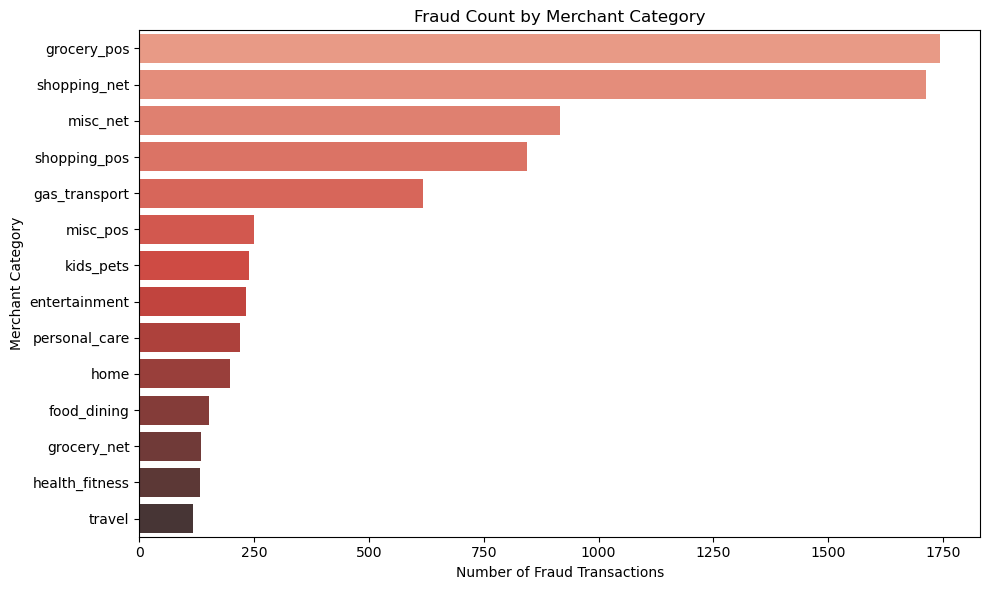

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count frauds by category
fraud_by_category = pdf[pdf["is_fraud"] == True].groupby("category").size().reset_index(name="fraud_count")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="fraud_count", y="category", data=fraud_by_category.sort_values("fraud_count", ascending=False), palette="Reds_d")
plt.title("Fraud Count by Merchant Category")
plt.xlabel("Number of Fraud Transactions")
plt.ylabel("Merchant Category")
plt.tight_layout()
plt.show()


C:\Users\iziss\AppData\Local\Temp\ipykernel_23888\1186943629.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="fraud_percent", y=category_group.index, data=category_group.reset_index().sort_values("fraud_percent", ascending=False), palette="coolwarm")


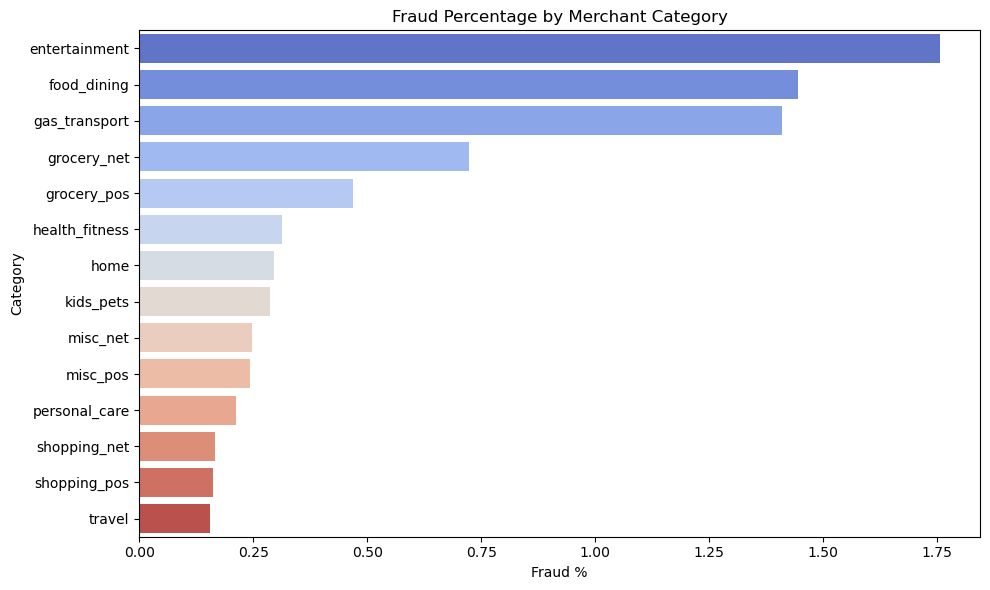

In [157]:
# Calculate fraud % by category
category_group = pdf.groupby("category")["is_fraud"].value_counts(normalize=True).unstack().fillna(0)
category_group["fraud_percent"] = category_group.get(True, 0) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="fraud_percent", y=category_group.index, data=category_group.reset_index().sort_values("fraud_percent", ascending=False), palette="coolwarm")
plt.title("Fraud Percentage by Merchant Category")
plt.xlabel("Fraud %")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


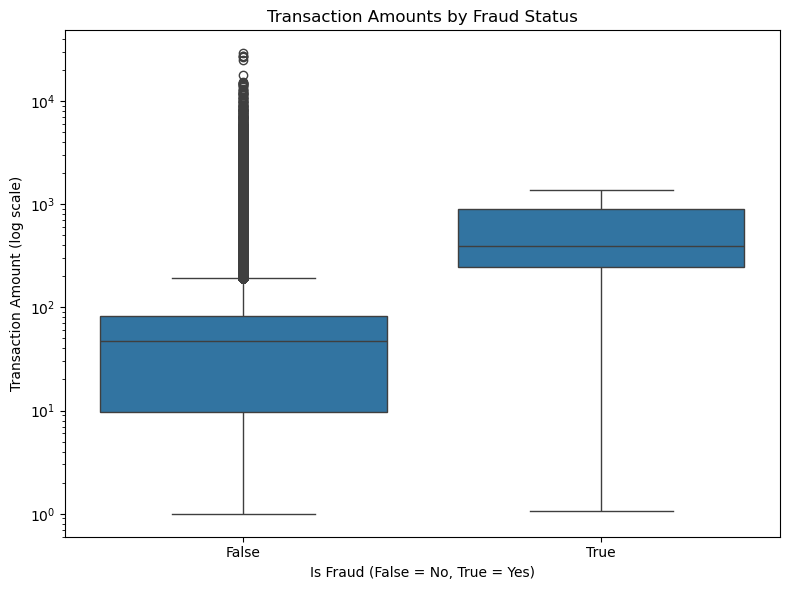

In [158]:
# Plot transaction amount distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x="is_fraud", y="amt", data=pdf)
plt.yscale('log')  # Use log scale for skewed data
plt.title("Transaction Amounts by Fraud Status")
plt.xlabel("Is Fraud (False = No, True = Yes)")
plt.ylabel("Transaction Amount (log scale)")
plt.tight_layout()
plt.show()


C:\Users\iziss\AppData\Local\Temp\ipykernel_23888\4101394041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="fraud_count", y="zip", data=top_zip, palette="magma")


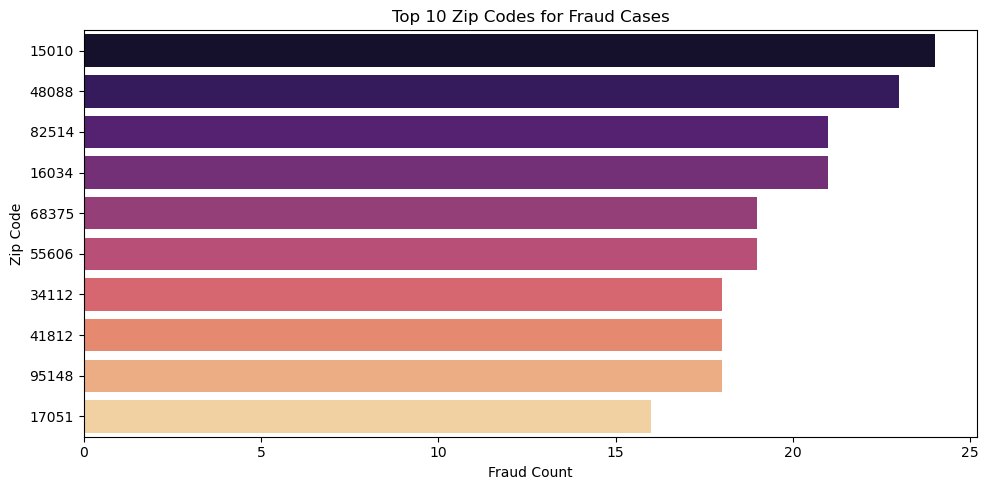

In [160]:
# Top zip codes where fraud occurred
top_zip = pdf[pdf["is_fraud"] == True].groupby("zip").size().reset_index(name="fraud_count").sort_values("fraud_count", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="fraud_count", y="zip", data=top_zip, palette="magma")
plt.title("Top 10 Zip Codes for Fraud Cases")
plt.xlabel("Fraud Count")
plt.ylabel("Zip Code")
plt.tight_layout()
plt.show()
